# Predicting Dota 2 Win Rates 

### Background 

Over the past year, I found myself captivated by the world of e-sports tournaments, particularly Dota 2, where the convergence of skill, strategy, and teamwork creates not only a fun-to-watch experience but also a plethora of questions to be answered by data scientists.

### About the game

Defense of the Ancients 2 (Dota 2) is an online multiplayer game where two teams of five players compete in a virtual battle arena. The goal of the game is to destroy the opponent's "ancient", a fancy structure on their half of the map, while defending your own. Each player controls a "hero" with unique base level abilities and roles. Throughout the game, players earn and spend gold, allowing them to level up, buy items, and become stronger. The game requires a high level of teamwork, communication, strategy, and quick decision-making to outsmart the opposing team, gain control over the map, and ultimately destroy the enemy's ancient to win.

### Data science for Dota 2

Dota 2 being one of the most popular and competetive online games, there is a plethora of data generated every day. Furthermore, the complex and dynamic nature of the game in itself is intriguing. Winning a game involves intricate strategies, team coordination, and individual player skills and in game choices. By employing machine learning techniques, we can delve deep into this complexity and reveal hidden patterns that contribute to winning or losing a game. 

### Goal 

The goal of this project is to build a model using player performance (win rate and KDA ratio) with their 9 most frequently played heroes, and then use the model to predict their performance for a 10th hero.

The dataset has around 2000 players, their most picked 10 heroes and their performance with each of these heroes. We also have information on the characteristics of each of these heroes, e.g. their roles, attack strengths, health, etc. 

### Data set

In this project, I'm utilizing a publicly available dataset from Kaggle:(https://www.kaggle.com/datasets/arashnic/dota2game).
***

<h1>Part 1: Data cleaning</h1>

In this part of the project, we are going to explore the dataset. We will clean the data if necessary, use statistical measures to analyze the data, and look at the relationship between different features while engineering and creating new features if necessary. So let's dive in!

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("train/train9.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    18846 non-null  int64  
 1   hero_id    18846 non-null  int64  
 2   id         18846 non-null  object 
 3   num_games  18846 non-null  int64  
 4   num_wins   18846 non-null  int64  
 5   kda_ratio  18846 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 883.5+ KB


In [4]:
train_data

,user_id,hero_id,id,num_games,num_wins,kda_ratio
0,1,74,1_74,304,185,3743.699732
1,1,65,1_65,255,151,4009.021513
2,1,39,1_39,203,135,5094.621514
3,1,106,1_106,158,106,4619.212963
4,1,2,1_2,157,94,2871.627907
...,...,...,...,...,...,...
18841,2992,8,2992_8,97,59,4153.992395
18842,2992,34,2992_34,93,40,3571.428572
18843,2992,70,2992_70,89,53,4212.180747
18844,2992,76,2992_76,290,211,5471.003135


The data frame we are looking at above has 6 columns. Let's have a look at what these column tags mean and decide whether we need all columns in the analysis.
***
**user_id**: the individual user tag (1-->2992) <br>
**hero_id**: the unique id of the hero which user selects<br>
**id**: a combination of user and hero id (unnecessary column)<br>
**num_games**: number of games a user played with a certain hero<br>
**num_wins**: number of games a user won, playing with a certain hero<br>
**kda_ratio**: kill-death-assist ratio, defined as ((Kills + Assists)\*1000/Deaths) 
***
These are the definitions given on kaggle for this particular dataset but I should mention that the kda_ratio multiplied by 1000 is unconventional. According to multiple gaming forums (and an in depth conversation I had with ChatGPT) KDA ratio is calculated simply by (Kills + Assists)/(Deaths+1), where +1 in the denominator makes sure that the ratio mathematically "makes sense" in case the number of Deaths is zero. So keeping that in mind, I think the kda_ratio provided in this data set is most likely pre-engineered to have the individual values scaled up. Indeed this method would make sense in terms of the precision we would like to achive in predictions. 

For example, working with a **kda_ratio** of 4396.396396 instead of 4.396396396 will reduce the numerical precision issues that might arise from having a large number of decimal places. 
***
We also need a normalized representation of win rate in a way that it's independent of the number of games a user plays. This will help us eliminate the bias introduced by the differences in the number of games played by different users. So instead of the original columns, we can further engineer the dataframe to convert the number of wins to win rates in percentages:

In [5]:
train_data["win_rate"] = train_data["num_wins"]*100 / train_data["num_games"]

# now we can also drop the columns we no longer need
train_data = train_data.drop(["num_games", "num_wins", "id"], axis=1)

Additionally, we have a supplementary dataset with information on the Dota 2 heroes. As each hero is unique in its ability and we can use this supplementary dataset to figure out "how". Let's look at this dataset below:

In [6]:
# read in the heroes dataset
heroes = pd.read_csv("./train/hero_data.csv")

Now let's look at the features of these heroes and delve deeper into the analysis.

In [7]:
heroes.columns

Index(['hero_id', 'primary_attr', 'attack_type', 'roles', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate'],
      dtype='object')

The heroes dataset (which we will merge with the train_data) shows all the features of Dota 2 heroes. First let's have a look at what these columns mean:
**hero_id**: unique id of a hero, same as in the train_data. <br>
**primary_attr**: A string for the primary attribute of the hero (it can be: int- initiator, agi- agility, str- strength) <br>
**attack_type**: A string for the attack type of the hero. It can be melee or ranged<br>
**roles**: An array of strings for the different roles which a hero plays (Support, Disabler, Nuker, etc.)<br>
**base_health**: Initial value of health that a hero starts the game with<br>
**base_health_regen**: Regeneration of health per second<br>
**base_mana**: Initial value of mana that a hero starts the game with<br>
**base_mana_regen**: regen of mana per second <br>
**base_armor**: Initial value of armor that a hero starts the game with<br>
**base_magic_resistance**: Initial value of magic resistance of a certain hero<br>
**base_attack_min**: min attack damage (a hero's attack could vary between a min-max range) <br>
**base_attack_max**: max attack damage<br>
**base_strength**: Base strength of a hero <br>
**base_agility**: Base agility of a hero <br>
**base_intellegence**: Base intellegence of a hero <br>
**strength_gain**: The strength gain of a hero per level <br>
**agility_gain**: The agility gain of a hero per level <br>
**intellegence_gain**: The intellegence gain of a hero per level <br>
**attack_range**: The distance a hero can stay from the target and still hit<br>
**projectile_speed**: The speed at which your shot (or spell) travels<br>
**attack_rate**: The speed at which a hero attacks per second<br>
**move_speed**: The speed at which a hero moves <br>
**turn_rate**: How long it will take a hero to turn 360 degrees (important for mobility, dodging, etc.)

In [8]:
heroes

,hero_id,primary_attr,attack_type,roles,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,...,base_agility,base_intelligence,strength_gain,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate
0,1,agi,Melee,Carry:Escape:Nuker,200,1.50,75,0.9,-1.0,25,...,22,12,1.3,2.8,1.8,150,0,1.45,310,0.5
1,2,str,Melee,Initiator:Durable:Disabler:Jungler,200,4.25,75,0.9,-1.0,25,...,20,18,2.8,2.2,1.6,150,900,1.70,290,0.6
2,3,int,Ranged,Support:Disabler:Nuker:Durable,200,1.50,75,0.9,1.0,25,...,23,23,2.4,2.4,2.4,400,900,1.70,310,0.6
3,4,agi,Melee,Carry:Disabler:Jungler:Nuker:Initiator,200,1.50,75,0.9,0.0,25,...,24,18,2.7,3.0,1.7,150,900,1.70,285,0.5
4,5,int,Ranged,Support:Disabler:Nuker:Jungler,200,1.50,75,0.9,-1.0,25,...,16,16,2.0,1.6,2.9,600,900,1.70,275,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,112,int,Ranged,Support:Disabler:Nuker,200,1.50,75,0.9,-1.0,25,...,16,25,2.4,1.9,3.1,425,700,1.70,285,0.5
111,113,agi,Ranged,Carry:Escape:Nuker,200,1.50,75,0.9,-2.0,25,...,15,24,3.0,1.8,2.6,625,900,1.70,280,0.6
112,114,agi,Melee,Carry:Escape:Disabler:Initiator,200,3.00,75,0.9,-3.0,25,...,22,20,2.8,3.2,1.8,300,900,1.70,300,0.6
113,119,int,Ranged,Support:Nuker:Disabler:Escape,200,1.50,75,0.9,-1.0,25,...,18,20,1.8,1.6,3.0,475,1200,1.30,295,0.7


We can see above that some of the features have string values. For the model to understand these values we need to one-hot encode them. For example, the hero with id=1 can play the roles --> Carry, Escape, and Nuker. If we convert these to a binary encoding Carry, Escape, and Nuker will be new features (columns) taking the values 1 or 0. 1 will mean that the hero plays a certain role and 0 not. So for hero 1, Carry, Escape, and Nuker features will take the value 1 and Support, Disabler, or Initiator will take 0.

We can do this step by step to better understand what the code is doing. We first deal with the **roles** column because it can take values separated by ":". We do this as follows, using the get_dummies function of pandas, specifying a separator so we can split the text:

In [9]:
# we first need to get the roles separated and then use one hot encoding
# and drop the original roles column

heroes = heroes.join(heroes['roles'].str.get_dummies(sep = ':')).drop(['roles'],axis=1)

Now let's look at what the above line of code did for our dataframe:

In [10]:
heroes

,hero_id,primary_attr,attack_type,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,...,turn_rate,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
0,1,agi,Melee,200,1.50,75,0.9,-1.0,25,27,...,0.5,1,0,0,1,0,0,1,0,0
1,2,str,Melee,200,4.25,75,0.9,-1.0,25,24,...,0.6,0,1,1,0,1,1,0,0,0
2,3,int,Ranged,200,1.50,75,0.9,1.0,25,37,...,0.6,0,1,1,0,0,0,1,0,1
3,4,agi,Melee,200,1.50,75,0.9,0.0,25,33,...,0.5,1,1,0,0,1,1,1,0,0
4,5,int,Ranged,200,1.50,75,0.9,-1.0,25,19,...,0.5,0,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,112,int,Ranged,200,1.50,75,0.9,-1.0,25,10,...,0.5,0,1,0,0,0,0,1,0,1
111,113,agi,Ranged,200,1.50,75,0.9,-2.0,25,29,...,0.6,1,0,0,1,0,0,1,0,0
112,114,agi,Melee,200,3.00,75,0.9,-3.0,25,27,...,0.6,1,1,0,1,1,0,0,0,0
113,119,int,Ranged,200,1.50,75,0.9,-1.0,25,25,...,0.7,0,1,0,1,0,0,1,0,1


If we scroll right, we can see new features created with each of the roles (Carry, Disabler, Durable, etc.) and the values assigned to them as 1/0 depending on the specific hero and the roles that they can take. Notice how we also dropped the column **roles** as we no longer need it.

We still have two features, **primary_attr** and **attack_type** which we need to use one-hot encoding for. So let's do that:

In [11]:
# there are still some columns with string values that need one hot encoding: primary attribute, attack type
heroes = pd.get_dummies(data=heroes, columns=['primary_attr','attack_type'])#.drop(['primary_attr','attack_type'], axis=1)


Let's have a look at the dataframe again to see how it got updated:

In [12]:
heroes

,hero_id,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,...,Initiator,Jungler,Nuker,Pusher,Support,primary_attr_agi,primary_attr_int,primary_attr_str,attack_type_Melee,attack_type_Ranged
0,1,200,1.50,75,0.9,-1.0,25,27,31,22,...,0,0,1,0,0,1,0,0,1,0
1,2,200,4.25,75,0.9,-1.0,25,24,28,25,...,1,1,0,0,0,0,0,1,1,0
2,3,200,1.50,75,0.9,1.0,25,37,43,23,...,0,0,1,0,1,0,1,0,0,1
3,4,200,1.50,75,0.9,0.0,25,33,39,23,...,1,1,1,0,0,1,0,0,1,0
4,5,200,1.50,75,0.9,-1.0,25,19,25,16,...,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,112,200,1.50,75,0.9,-1.0,25,10,17,24,...,0,0,1,0,1,0,1,0,0,1
111,113,200,1.50,75,0.9,-2.0,25,29,39,24,...,0,0,1,0,0,1,0,0,0,1
112,114,200,3.00,75,0.9,-3.0,25,27,33,18,...,1,0,0,0,0,1,0,0,1,0
113,119,200,1.50,75,0.9,-1.0,25,25,33,18,...,0,0,1,0,1,0,1,0,0,1


If we slide the scroller all the way to the right we can see the new features added based off of the old columns we selected for one-hot encoding. Now we no longer have string values in our data frame, however, we still need to make sure that all the columns we have are useful for modelling and also they are clean (no missing values, NaNs).

So let's first check if there are any columns that have constant values. If they do, these features will not be useful for modeling because they are all the same for all heroes.

In [13]:
# check for columns with constant values using the built in nunique function
def remove_constant_value_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

columns_to_drop = remove_constant_value_columns(heroes)

In [14]:
columns_to_drop

['base_health', 'base_mana', 'base_mana_regen']

We can see that 3 columns in our heroes data frame are actually constant throughout the dataset. We do not need them as they do not tell us anything unique about a hero. So let's drop them:

In [15]:
heroes = heroes.drop(columns_to_drop, axis=1)

Another thing that might occur in large datasets is NaN values. So let's scan the data frame for that. Notice how we are using in built pandas functions for these operations, instead of writing loops to go through all values. Vectorized operations as these work much faster than loops, they are efficient and elegant.

In [16]:
# check for NaN values
heroes.isna().any()

hero_id                  False
base_health_regen        False
base_armor               False
base_magic_resistance    False
base_attack_min          False
base_attack_max          False
base_strength            False
base_agility             False
base_intelligence        False
strength_gain            False
agility_gain             False
intelligence_gain        False
attack_range             False
projectile_speed         False
attack_rate              False
move_speed               False
turn_rate                False
Carry                    False
Disabler                 False
Durable                  False
Escape                   False
Initiator                False
Jungler                  False
Nuker                    False
Pusher                   False
Support                  False
primary_attr_agi         False
primary_attr_int         False
primary_attr_str         False
attack_type_Melee        False
attack_type_Ranged       False
dtype: bool

The output above tells us that there aren't any NaN values in the heroes data frame. Now we can merge the two datasets train_data and heroes together. The column **hero_id** is the same for both data frames, therefore we will merge based on this feature as the following:

In [17]:
train_data_merged = pd.merge(train_data, heroes, on='hero_id')

In [18]:
train_data_merged

,user_id,hero_id,kda_ratio,win_rate,base_health_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,...,Initiator,Jungler,Nuker,Pusher,Support,primary_attr_agi,primary_attr_int,primary_attr_str,attack_type_Melee,attack_type_Ranged
0,1,74,3743.699732,60.855263,1.5,-1.0,25,19,25,16,...,0,0,1,1,0,0,1,0,0,1
1,2,74,3061.059634,55.098935,1.5,-1.0,25,19,25,16,...,0,0,1,1,0,0,1,0,0,1
2,5,74,3899.408284,57.971014,1.5,-1.0,25,19,25,16,...,0,0,1,1,0,0,1,0,0,1
3,6,74,3802.301964,56.271186,1.5,-1.0,25,19,25,16,...,0,0,1,1,0,0,1,0,0,1
4,8,74,3830.321521,58.846154,1.5,-1.0,25,19,25,16,...,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,1759,37,3352.402746,65.591398,1.5,1.0,25,22,32,22,...,1,0,0,0,1,0,1,0,0,1
18842,2132,37,3944.157187,60.096154,1.5,1.0,25,22,32,22,...,1,0,0,0,1,0,1,0,0,1
18843,2188,37,4206.225681,53.571429,1.5,1.0,25,22,32,22,...,1,0,0,0,1,0,1,0,0,1
18844,2808,37,2227.525855,55.276382,1.5,1.0,25,22,32,22,...,1,0,0,0,1,0,1,0,0,1


Et voilá! Now in our merged data frame we have the user information (heroes that they use and the corresponding win rates) and also the features of each individual hero that a user has played with.

Before we go on further, I would like to check if there are any missing values in the merged data frame. We can do this as the following:

In [19]:
train_data_merged.isnull().values.any()

False

Great! Our data frame is free of missing values and NaNs, ready to be analyzed!

<h1>Part 2: Data exploration</h1>


Out of curiosity, we can look at how many times a certain hero is selected. This should have a minor impact on the outcome of the game as there are 5 heroes that each team picks and the course of the game depends more on the entire draft (selection of all 5 heroes) of a team rather than individual heroes. However, there are times throughout the year where certain heroes and their abilities gets boosted or nerfed, which ultimately (and temporarily) makes certain heroes more popular than others.

In [20]:
# import the plotting wrappers
from plot_utils2 import plot_data

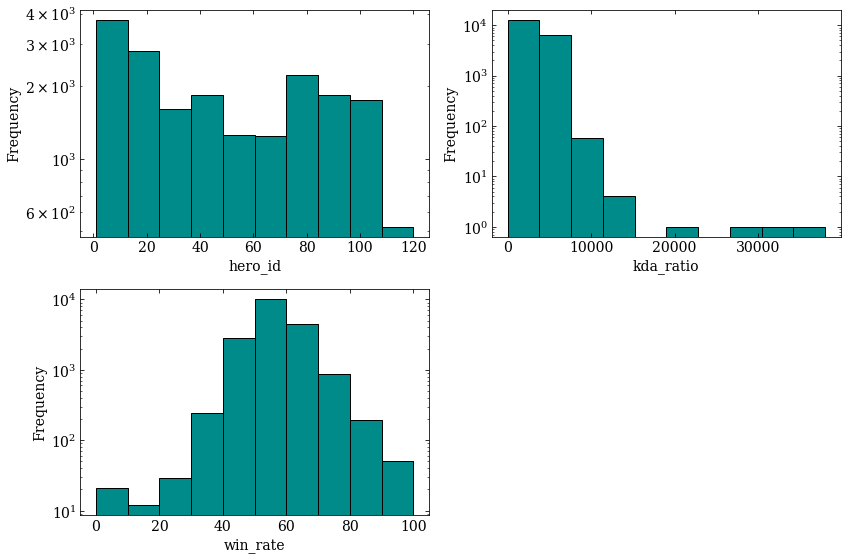

In [21]:
plot_data(train_data_merged, plot_type='histogram', columns=["hero_id","kda_ratio","win_rate"],
          logy=True, subplot=True, figsize=(12,8))

In [22]:
train_data_merged[["kda_ratio","win_rate"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
kda_ratio,18846.0,3543.462003,1081.195070,0.0,2841.265936,3403.463637,4073.493596,38000.0
win_rate,18846.0,56.643512,8.485105,0.0,51.707317,56.172840,60.919540,100.0


In the above histogram plots, we can see: <br>
(1) that the distribution of hero selection is spread accross almost all bins (except for perhaps hero_id's > 100)<br>
(2) most players (75%) have a kda_ratio of less than 4, with a median of 3.4. <br>
(3) most players (75%) have a win_rate less than 60%, with a median of 56%.

We can also have a look at the distribution of hero characteristics: 

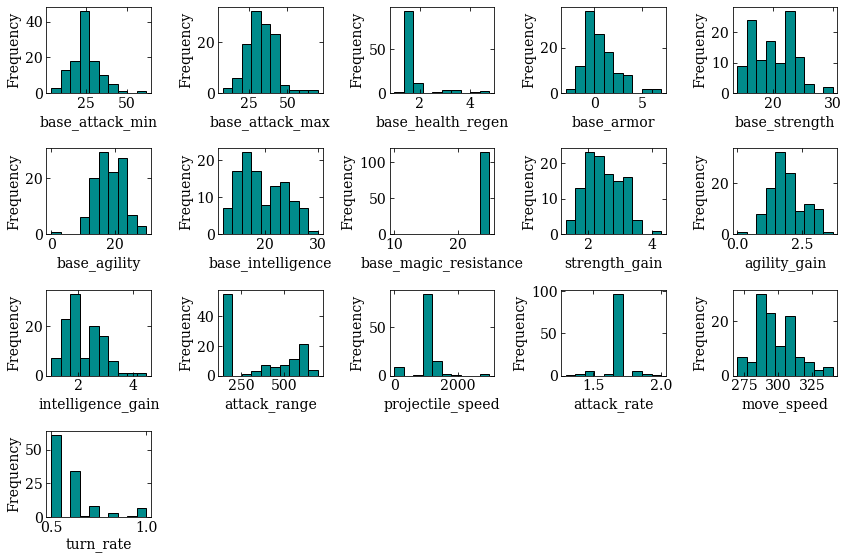

In [23]:
columns = ["base_attack_min","base_attack_max", "base_health_regen", "base_armor",
          "base_strength","base_agility", "base_intelligence", "base_magic_resistance", "strength_gain",
          "agility_gain","intelligence_gain","attack_range","projectile_speed",
          "attack_rate","move_speed","turn_rate"]
plot_data(heroes, plot_type='histogram', columns=columns,
          subplot=True, figsize=(12,8))

When looking at these plots, we have to consider that the Dota 2 heroes (their abilities) are intentionally constructed to fit certain roles and their attributes, strengths and weaknesses, are engineered to fit these roles. They are not coincedential. 

One histogram that struck me as unusual is the one which shows **base_magic_resistance**. I initially thought maybe this was a feature with constant values throughout the dataset but was not deleted in Part 1 due to a bug in my code. But if we look into this hero attribute further with a scatter plot:  

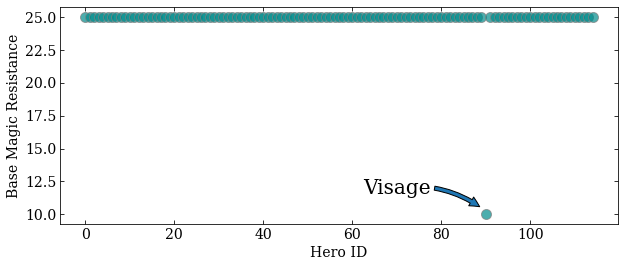

In [24]:
plt.figure(figsize=(10,4))
plt.scatter(x=np.arange(0,115),y=heroes["base_magic_resistance"],marker='o',s=100, color='#008B8B',alpha=0.7, edgecolor='gray')
plt.ylabel('Base Magic Resistance')
plt.xlabel('Hero ID')

plt.annotate("Visage",
            xy=(89,10.5), xycoords='data',
            xytext=(70, 12), textcoords='data',
            size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"))
plt.show()

As we can see in the above plot, there is just 1 hero with **base_magic_resistance** that is at 10 unlike all the rest of the heroes with 25. My internet search revealed that this is no bug, no data scraping malfunction, but indeed there is a single hero in the game, named Visage, that starts the game with less magic resistance than any other hero. This is because there are other attributes that make Visage so strong in the early game, to balance out these Visage starts the game with less magic resistance than the rest of the heroes. <br>
(source: https://www.reddit.com/r/DotA2/comments/313ni5/what_heroes_that_start_with_less_than_25_magic/). 

For the rest of hero perks shown in the set of histograms above, we can see that hero abilites are distributed mostly normally with some of them being bimodal. These distributions are not coincidential. All heroes are engineered to have strengths and weaknesses depending on their role in the game. 

***
Now, let's look at how these abilities correlate with one another and what kind of impact they have on the outcome of the game.

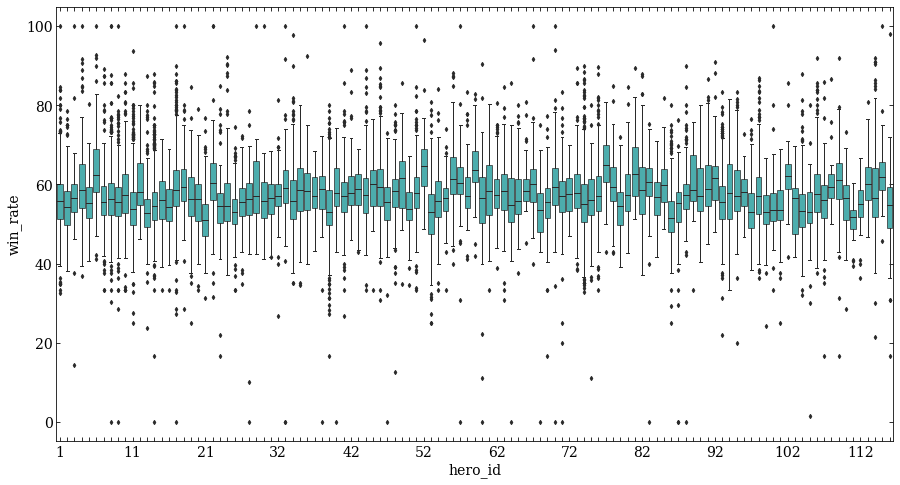

In [25]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data=train_data_merged, x="hero_id", y="win_rate",
                 color="#008B8B", saturation=1, fliersize=3,
                boxprops=dict(alpha=.7))

n = 10  # Keeps every 10th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.show()

The above plot is what is called a box plot and it is useful when visualizing quantitative data. Each individual box shows the interquartile range (quartiles 1 and 3) with the horizontal line in the middle which shows the median value. The "whiskers", vertical lines above and below the boxes, show the minimum and maximum values. The diamonds show the outliers.

Our plot above shows how the win rate varies across a selection of different heroes. As expected, the win rate is independent of the selection of individual heroes at approximately 60%. There are *some* variations in the win rate, but with the current information we have, this will not be enough for predictions. Let's further analyze the correlations!

**Note on the outliers:** the boxplot function in seaborn package uses a parameter named "whis" for the extent of the whiskers. By default this parameter is set to 1.5, which allows the whiskers to extend to 1.5 times the interquartile range (the widht of the box). The value of 1.5 is optional, though it is in line with the statistical conventions, i.e. Turkey's method -- a statistical method for identifying outliers.
***

Below, we look at dependence of the **win_rate** on the **kda_ratio** with data points colored according to the hero attribute **Carry**. We are using this particular attribute for a few reasons: <br>
(1) Carry heroes are given farm (experience and gold) priority so they can become stronger throughout the game<br>
(2) Their damage potential scales very well towards the and game as attributes are designed for this purpose<br>
(3) Heroes in **Support** roles support the carries, providing them with space and opportunities to make the kills<br>
(4) Carries reach their high damage potential in the late game, often responsible for most of the damage and kills<br>

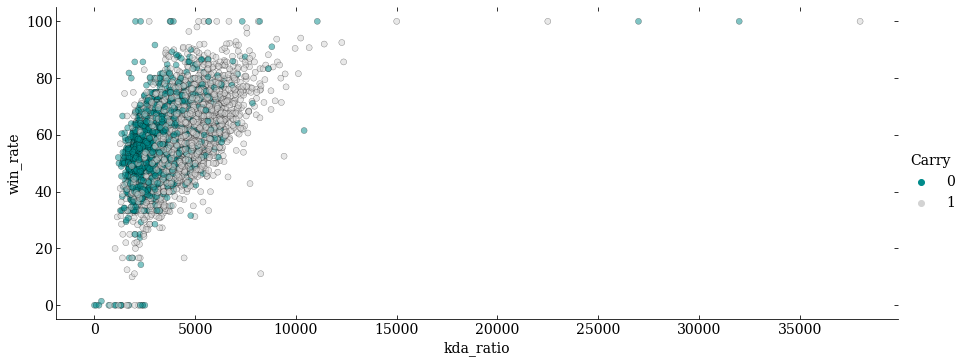

In [26]:
g = sns.relplot(x='kda_ratio', y='win_rate', 
            hue='Carry', data=train_data_merged,
            alpha=.5, palette=["#008B8B","#D3D3D3"],
            aspect=2.5, linewidth=0.4, edgecolor="k")

In the scatter plot above, we are demonstrating a categorical divide between the heroes: those that are carries (light gray points) and those that are not (green points). A player's **kda_ratio** correlate well with their chances of winning the game. The correlation is stronger for the case of carry heroes.
***
Now we can check for correlations in the entire dataset. Below is a correlation matrix for the pairs of features and the colors indicate the strength and the direction of the correlation. Values close to 1 (and -1) indicate high correlation. 

<AxesSubplot:>

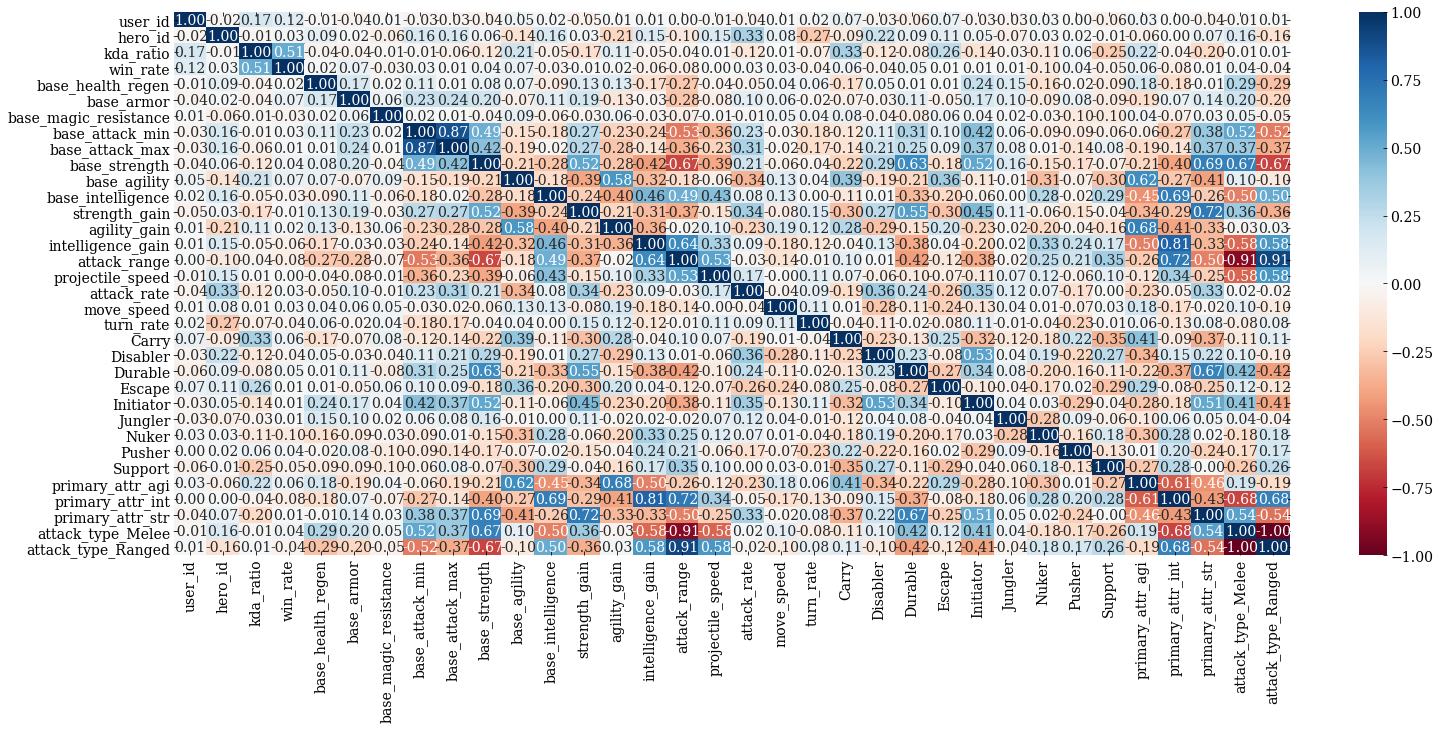

In [27]:
plt.figure(figsize=(25,10))
sns.heatmap(train_data_merged.corr(), annot=True, fmt='.2f', cmap='RdBu', vmax=1, vmin=-1, center=0)

Due to the large number of features, the above plot is a little crowded -- even though we can pick out the high correlation clusters clearly as they stand out from the rest with their dark blue or red colors. To make this plot a bit more visually elegant and easier to understand, we can mask out the low correlation values and replot using those features which are highly correlated:

<AxesSubplot:>

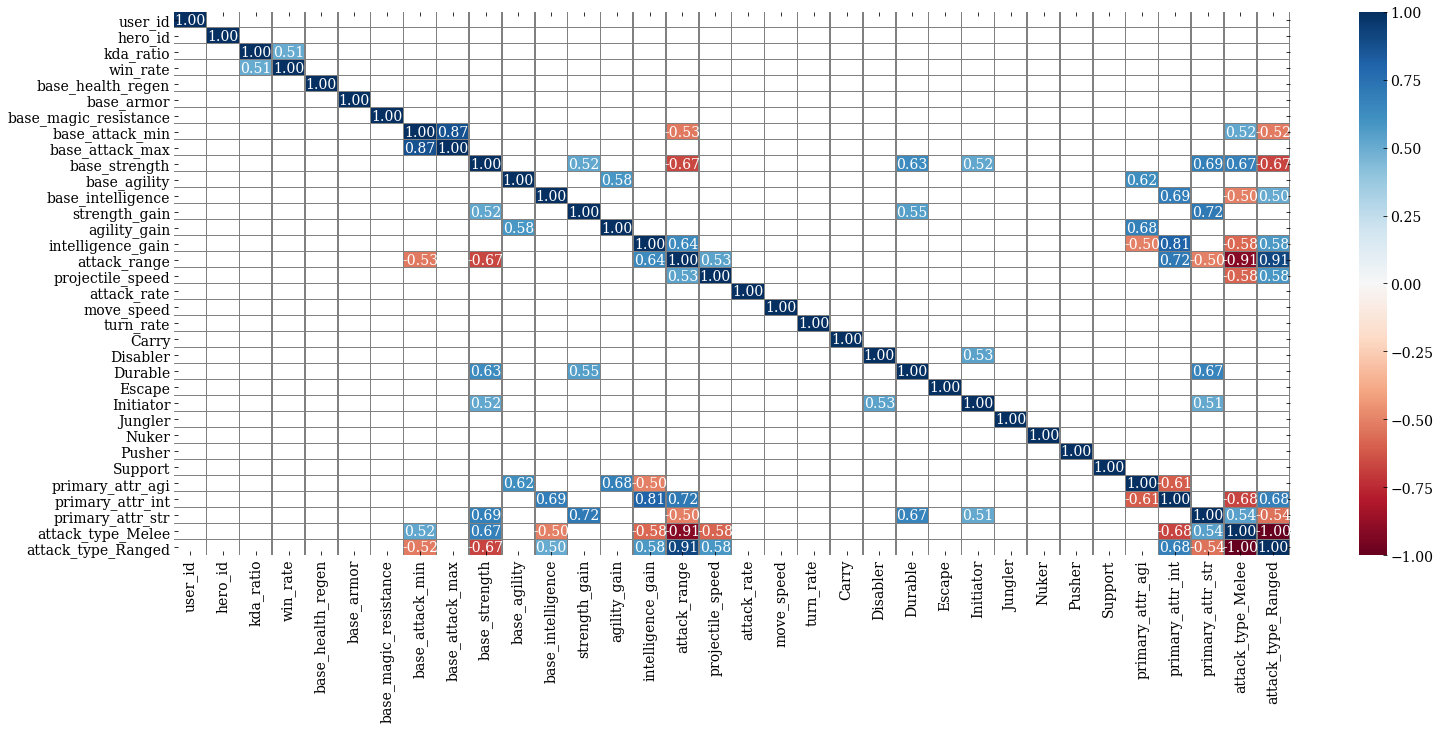

In [28]:
dfCorr = train_data_merged.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5))]# & (dfCorr !=1.000)]

plt.figure(figsize=(25,10))
sns.heatmap(filteredDf, annot=True, fmt='.2f', cmap='RdBu', 
            vmax=1, vmin=-1, center=0, linewidths=0.5, linecolor='grey')

Now we are left with the strongest correlations for our data sets. The diagonal components are all equal to 1, because these are the correlations for an attribute with itself. How do we interpret these correlations? I can assure you these are going to become very intuitive as we dig further:

(1) In the case of **attack_type_Melee** and **attack_type_Ranged** there is a strong negative correlation which is expected because they represent opposite characteristics: melee attacks are close-ranged, whiles ranged attacks often involve projectiles with a trajectory and speed. <br>
(2) Heroes with high **base_strength** have strength as their primary attributes (not unexpected). But also, there is a high correlation with **base_strength** with the hero attack types (melee or ranged). This is pure role design and balance. How? Well, melee heroes are often in close combat which requires them to be more durable, hence the higher strength, while ranged heroes are more fragile and their survival depends on their positioning and mobility.<br>
(3) Similarly Initiator and Durable heroes have higher **base_strength**, which provides them with durability to start fights, distrup enemy positioning, and absorb damage.<br>
(4) We see a moderate relationship between the melee/ranged hero types and their **base_intellegence**. Intellegance in Dota 2 often shows a hero's spell casting abilities. Melee heroes are often in close-combat, relying on their physical damage, while ranged heroes may spellcast from a distance.<br>
(5) Following the same line of thought, high intellegence heroes are more likely to be able to cast spells from a safer distance, hence, the correlation between **primary_attr_int** and **attack_range**.<br>
(6) The anti-correlation between primary attributes intellegence and agility is also a deliberate choice of game design to create distinct role for heroes, i.e. intellegence heroes spell cast and rely on their mana pool while agility heroes deal physical damage relying on their attack speed and damage output. <br>

While these correlations are a part of how the developers intended the gameplay to be, there are strong variations among individual heroes with their unique abilities and attributes, further promoting strategical in-game thinking.

<h1>Part 3: Predicting user performance </h1>


In the previous parts of the project, we looked at player performance with their most played 9 heroes. Now the question is whether we can train a machine learning model to predict the same players' performance with a 10th hero. In the below dataset, we have the same players' performance with their 10th hero, therefore we can compare our prediction with the actual user performance to evaluate the model. Let's start! 
***
We first need to process the test data in the same way as the train_data:


In [29]:
test_data = pd.read_csv("./train/train1.csv")
test_data

,user_id,hero_id,id,num_games,num_wins,kda_ratio
0,1,41,1_41,201,125,3731.707317
1,2,17,2_17,427,234,2922.058381
2,5,106,5_106,240,130,5116.682739
3,6,65,6_65,206,122,4131.553861
4,7,69,7_69,697,382,2474.469306
...,...,...,...,...,...,...
2089,2986,76,2986_76,21,14,4250.000000
2090,2989,27,2989_27,28,20,2368.888889
2091,2990,9,2990_9,260,132,3540.922619
2092,2991,33,2991_33,171,118,3933.422104


In [30]:
test_data["win_rate"] = test_data["num_wins"]*100 / test_data["num_games"]
test_data = test_data.drop(["num_games", "num_wins", "id"], axis=1)
test_data_merged = pd.merge(test_data, heroes, on='hero_id')
test_data_merged

,user_id,hero_id,kda_ratio,win_rate,base_health_regen,base_armor,base_magic_resistance,base_attack_min,base_attack_max,base_strength,...,Initiator,Jungler,Nuker,Pusher,Support,primary_attr_agi,primary_attr_int,primary_attr_str,attack_type_Melee,attack_type_Ranged
0,1,41,3731.707317,62.189055,2.0,0.0,25,33,39,23,...,1,0,0,0,0,1,0,0,1,0
1,25,41,4976.351351,59.722222,2.0,0.0,25,33,39,23,...,1,0,0,0,0,1,0,0,1,0
2,78,41,3194.369973,59.848485,2.0,0.0,25,33,39,23,...,1,0,0,0,0,1,0,0,1,0
3,97,41,2933.531746,56.772334,2.0,0.0,25,33,39,23,...,1,0,0,0,0,1,0,0,1,0
4,277,41,2606.365159,46.250000,2.0,0.0,25,33,39,23,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,1451,79,2631.449631,43.859649,1.5,0.0,25,27,31,21,...,1,0,1,0,1,0,1,0,0,1
2090,2066,79,2842.729970,56.666667,1.5,0.0,25,27,31,21,...,1,0,1,0,1,0,1,0,0,1
2091,1623,89,3097.588978,50.632911,3.0,3.0,25,23,25,21,...,1,0,0,1,1,1,0,0,1,0
2092,1817,94,3777.777778,80.000000,1.5,-1.0,25,24,30,14,...,0,0,0,0,0,1,0,0,0,1


Our target variables are **kda_ratio** and **win_rate**. Let's first predict **win_rate**:

In [31]:
X_train, y_train = train_data_merged.drop(["win_rate"], axis=1), train_data_merged["win_rate"]
X_test, y_test = test_data_merged.drop(["win_rate"], axis=1), test_data_merged["win_rate"]

Here is where we have to choose our model. Decision trees work well on structured datasets, they're efficient and fast. In this work we will use the XGBoost (Extreme Gradient Boosting) library which is an open source implementation of boosted trees. As our target variables (both in the case of **win_rates** and **kda_ratio**) are continous, we will use XGBRegressor which is a model specifically for regression problems.

In [32]:
from xgboost import XGBRegressor

# let's create an instance of thr model
xgb_model = XGBRegressor()

In [33]:
# Fit the model to the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
# now we can use the model to make predictions on the test data
y_pred = xgb_model.predict(X_test)

# and print the results
pred_win_rates = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(pred_win_rates)

         Actual  Predicted
0     62.189055  60.063725
1     59.722222  65.573677
2     59.848485  56.485535
3     56.772334  55.609425
4     46.250000  51.061977
...         ...        ...
2089  43.859649  54.732742
2090  56.666667  58.074535
2091  50.632911  55.002277
2092  80.000000  63.175972
2093  23.076923  36.779484

[2094 rows x 2 columns]


We can visualize the predicted **win_rates** versus the true **win_rates**:

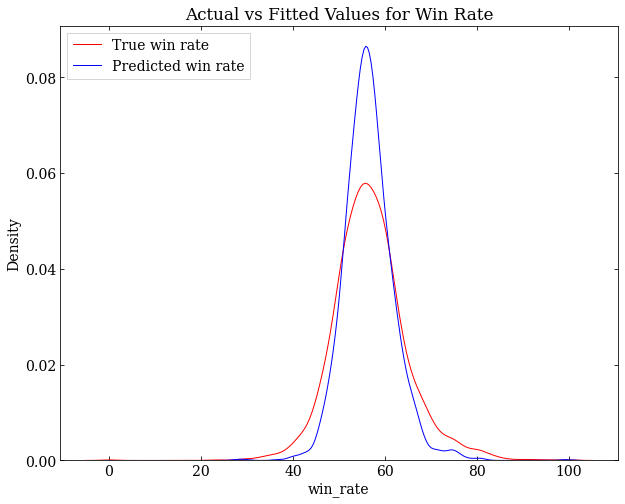

In [35]:
plt.figure(figsize=(10, 8))

ax = sns.distplot(y_test, hist=False, color="r", label="True win rate")
sns.distplot(y_pred, hist=False, color="b", label="Predicted win rate" , ax=ax)
plt.title('Actual vs Fitted Values for Win Rate')
plt.legend(loc=2)

From the above plot, we can see that our model is not performing great.. Another way to have a look at this is to do a scatter plot to visualize a subset of samples. The reason why I would like to look at a subset is because we have over a 2000 predictions, and that would be a crowded plot! Of course these aren't really quantitative measures to see how well our model has worked, but they are visualizations to give us a bit of an intuition about the model.

Let's have a look at the first 100 samples and the predictions:

In [36]:
y_test_subset = y_test[0:100]
y_pred_subset = y_pred[0:100]

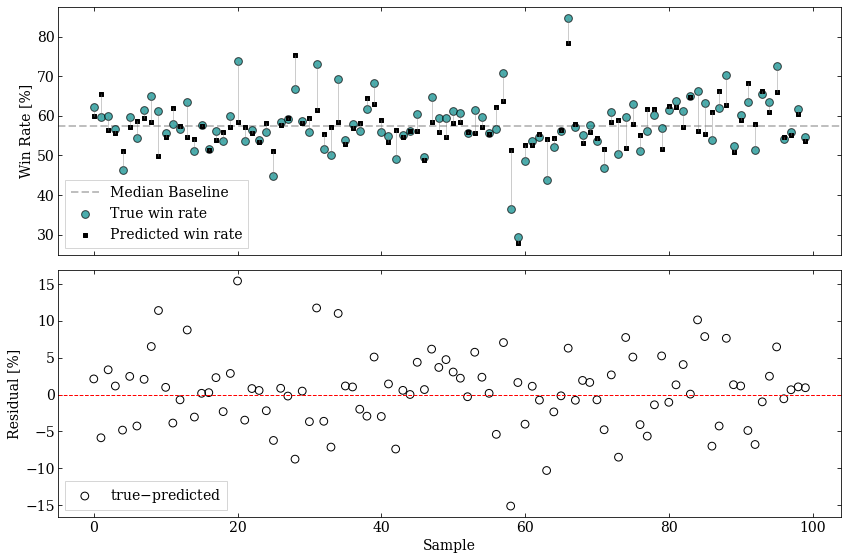

In [37]:
from plot_utils2 import trueVSpred_scatter
trueVSpred_scatter(y_test_subset,y_pred_subset,figsize=(12, 8))

Above are two scatter plots. In the uppper panel, we are looking at the true **win_rates** (green circles) and the predicted **win_rates** (black squares) for each observation in the subset. To compare the XGBRegressor performance to a simple dummy model we also have the median **win_rate** represented with the gray dashed line. The bottom panel shows the residuals of the true **win_rates** and the final model prediction. In this case a *perfect* fit yield 0% residuals (red dashed line), meaning the model has predicted the exact target variable. However, this is also not what we want as a perfect fit would mean that the model is overfitting. 

Now let's look at our model's results more quantitatively:

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("#############################")
print("XGBoost Regressor model")
print("-----------------------------")

mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

####
print(' ')
print("Median baseline model")
print("-----------------------------")
median_win_rate = np.median(y_test)
y_pred_baseline = np.full_like(y_test, fill_value=median_win_rate)

# Calculate RMSE for y_pred_baseline
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Calculate R-squared score for y_pred_baseline
r2_baseline = r2_score(y_test, y_pred_baseline)

print("Root Mean Squared Error:", rmse_baseline)
r2 = r2_score(y_test, y_pred_baseline)
print("R-squared Score:", r2)
print("#############################")


#############################
XGBoost Regressor model
-----------------------------
Root Mean Squared Error: 6.041638734877059
R-squared Score: 0.4192985542316785
 
Median baseline model
-----------------------------
Root Mean Squared Error: 7.943524487003358
R-squared Score: -0.003852440639133592
#############################


As we saw in our scatter plots above, our XGBRegressor model is doing much better than a dummy baseline model. More specifically, the higher R-squared score means that a higher proportion of the variation in win_rates can be attributed to the features that our model is using. Quantitavely, an R-squared of 0.4 means that approximately 40% of variation in **win_rates** is accounted for by our XGBRegressor predictions. We can draw a similar conclusion from the RMSEs that we get from the two different models. An rmse of 6.0 for the XGBRegressor model means that the average variation in the predicted and true win rates is around 6% (note that the percentage in this case is the unit of the target variable itself).

Now the question is whether we can improve the model. When we fit the XGBRegressor model above, we used the default values of the model hyperparameters. Scikit-learn allows us to do a *grid search* with cross validation for hyperparameter tuning, so we can try out different combbinations of hyperparameters to see if our model can be improved. Note that this is **not** the only way to improve a model, but it is a step towards diving deeper into understanding our model which otherwise might turn out to be just a black box.

In [39]:
from grid_search import run_grid_search

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
RMSE: 6.185725848466536
R-squared: 0.3912699542691085


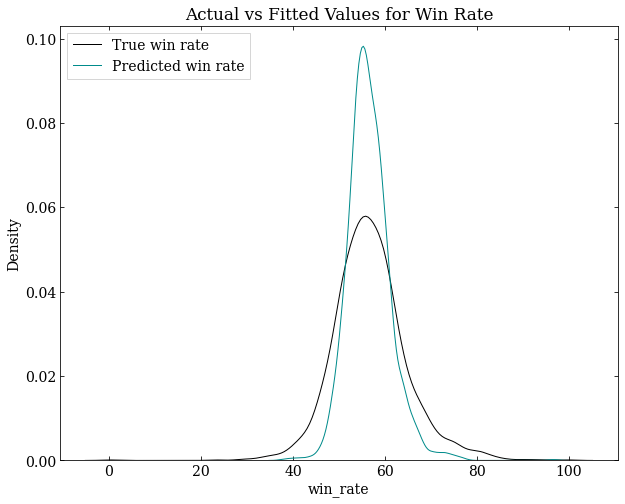

In [40]:
model = XGBRegressor()
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    }
scoring = 'r2'
best_model, rmse, r2 = run_grid_search(X_train, y_train, X_test, y_test,
                                      model, cv=5, param_grid=param_grid, scoring=scoring)

Grid search with an optimized set of hyperparameters did not actually make our model any better. Before we delve into analyzing further to figure out what went wrong. I will trust my intuition which tells me that model's performance is actually a result of the narrow target value distribution. If we go back and have a look at the initial data exploration plots that we made, we can see that the mean **win_rate** in the training dataset has a standard deviation of 8% --> $56.6\pm8.5\%$. Let's see if XGBRegressor can create a model that performs better when the target variable is the **kda_ratio**.

We start with similarly setting up our training and test datasets:

In [41]:
X_train_kda, y_train_kda = train_data_merged.drop(["kda_ratio"], axis=1), train_data_merged["kda_ratio"]
X_test_kda, y_test_kda = test_data_merged.drop(["kda_ratio"], axis=1), test_data_merged["kda_ratio"]

In [42]:
# let's create a new instance of the model
xgb_model_kda = XGBRegressor()
# Fit the model to the training data
xgb_model_kda.fit(X_train_kda, y_train_kda)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
# now we can use the model to make predictions on the test data
y_pred_kda = xgb_model_kda.predict(X_test_kda)

# and print the results
pred_kda = pd.DataFrame({'Actual': y_test_kda, 'Predicted': y_pred_kda})
print(pred_kda)

           Actual    Predicted
0     3731.707317  3403.740479
1     4976.351351  4303.987793
2     3194.369973  3671.989258
3     2933.531746  3553.588379
4     2606.365159  3146.947998
...           ...          ...
2089  2631.449631  2357.625000
2090  2842.729970  2653.285645
2091  3097.588978  3371.491211
2092  3777.777778  4822.389648
2093  1608.108108  2038.771851

[2094 rows x 2 columns]


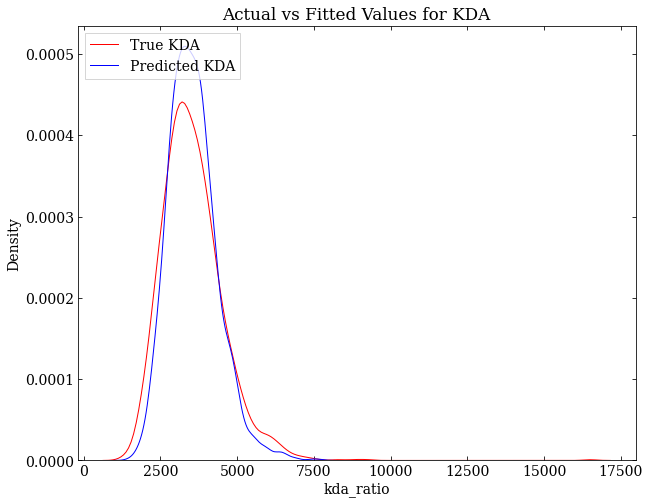

In [45]:
plt.figure(figsize=(10, 8))

ax = sns.distplot(y_test_kda, hist=False, color="r", label="True KDA")
sns.distplot(y_pred_kda, hist=False, color="b", label="Predicted KDA" , ax=ax)
plt.title('Actual vs Fitted Values for KDA')
plt.legend(loc=2)

In [46]:
print("#############################")
print("XGBoost Regressor model")
print("-----------------------------")

mse_kda = mean_squared_error(y_test_kda, y_pred_kda)
#print("Mean Squared Error:", mse)
rmse_kda = np.sqrt(mse_kda)
print("Root Mean Squared Error:", rmse_kda)
r2_kda = r2_score(y_test_kda, y_pred_kda)
print("R-squared Score:", r2_kda)

####
print(' ')
print("Median baseline model")
print("-----------------------------")
median_kda = np.median(y_test_kda)
y_pred_baseline_kda = np.full_like(y_test_kda, fill_value=median_kda)

# Calculate RMSE for y_pred_baseline
rmse_baseline_kda = np.sqrt(mean_squared_error(y_test_kda, y_pred_baseline_kda))

# Calculate R-squared score for y_pred_baseline
r2_baseline_kda = r2_score(y_test_kda, y_pred_baseline_kda)

print("Root Mean Squared Error:", rmse_baseline_kda)
r2_kda = r2_score(y_test_kda, y_pred_baseline_kda)
print("R-squared Score:", r2_kda)
print("#############################")


#############################
XGBoost Regressor model
-----------------------------
Root Mean Squared Error: 600.256502968405
R-squared Score: 0.6445217102509867
 
Median baseline model
-----------------------------
Root Mean Squared Error: 1015.0810126513907
R-squared Score: -0.016578084928342784
#############################


Now we can see that an XGBRegressor model (even with default hyperparameter settings) works so much better for predicting the **kda_ratio**. We are still doing better than a simple median baseline model and our XGBRegressor model is able to capture approximately 65% of the variability observed in the **kda_ratio**.  

# What can we do better?
Well, there are a few steps to consider when thinking about future work and improvements to the current models: <br>
(1) it would be beneficial to expand the hyperparameter search grid and tune parameters such as gamma, reg_alpha, and reg_lambda. This step is computationally costly therefore it is marked as future work :) <br>
(2) we can try a different model such as a random forest regressor to see if another model works better at predicting our target variables.

But for now we will wrap up here and move onto the next project!